<a href="https://colab.research.google.com/github/yelin1197/ICT/blob/main/%5BKISIA%5D_Automotive_IDS_(ML)_%EC%8B%A4%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download

In [1]:
# 구글 드라이브에 저장된 파일을 다운로드 하기 위한 라이브러리 설치
!pip install gdown

In [8]:
# Sample 파일 다운로드
!gdown --id 1FTjcnWC8bXgN8AI0hT0l16KvardlOQEj --output Sample_Train_Dataset.csv
!gdown --id 1q_ALDNEsxsvA1hXoR7Mw3E90Nl5RjJDj --output Sample_Test_Dataset.csv
!gdown --id 1JOvqTZSlxgoCQInmRbsVVylBrs0SXjt6 --output Sample_Answer.csv

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1FTjcnWC8bXgN8AI0hT0l16KvardlOQEj
To: /content/Sample_Train_Dataset.csv
100% 15.7M/15.7M [00:00<00:00, 104MB/s] 
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1q_ALDNEsxsvA1hXoR7Mw3E90Nl5RjJDj
To: /content/Sample_Test_Dataset.csv
100% 13.6M/13.6M [00:00<00:00, 104MB/s] 
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Download

In [9]:
# 현재 디렉토리의 파일 목록 확인
!ls

Sample_Answer.csv  sample_data	Sample_Test_Dataset.csv  Sample_Train_Dataset.csv


# Library

In [7]:
# 라이브러리 호출
import joblib
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

# Dataset

In [6]:
# Sample 파일 경로 설정
sample_train_file = './Sample_Train_Dataset.csv'
sample_test_file = './Sample_Test_Dataset.csv'
sample_answer_file = './Sample_Answer.csv'

# Train

In [10]:
# Sample_Train_Dataset 파일 불러오기
train_msg = pd.read_csv(sample_train_file)
print(train_msg)

         Timestamp Arbitration_ID  DLC                     Data   Class
0         0.066729            316    8  45 32 1A 0A 32 28 00 7F  Normal
1         0.066965            18F    8  FE 65 32 00 00 43 00 00  Normal
2         0.067199             80    8  00 17 1A 0A 32 28 32 3C  Normal
3         0.067438             81    8  40 84 89 00 00 00 00 3C  Normal
4         0.067678            165    8  11 F8 7F 00 00 00 0A 9C  Normal
...            ...            ...  ...                      ...     ...
325227  143.297302            440    8  FF 00 00 00 FF 40 09 00  Normal
325228  143.298875            316    8  45 32 CC 09 32 27 00 7F  Normal
325229  143.299325            329    8  84 B1 7E 8C 11 36 00 10  Normal
325230  143.299557            545    8  C8 13 00 8A 5B 00 5F 00  Normal
325231  143.299795             80    8  00 17 CC 09 32 27 32 AA  Normal

[325232 rows x 5 columns]


In [4]:
# Feature를 생성하기 위한 전처리 함수 정의
def preprocessing(msg):
  df = pd.DataFrame(columns=['ID', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8'])

  # ID
  df['ID'] = msg['Arbitration_ID'].apply(int, base=16)

  # Data
  _data = []
  for i in msg['Data'].values:
    line = i.split(' ')

    if len(line) < 8:
      line += ['00'] * (8 - len(line))

    _data.append([int(l, 16) for l in line])
  data = np.array(_data)

  df['D1'] = data[:, 0]
  df['D2'] = data[:, 1]
  df['D3'] = data[:, 2]
  df['D4'] = data[:, 3]
  df['D5'] = data[:, 4]
  df['D6'] = data[:, 5]
  df['D7'] = data[:, 6]
  df['D8'] = data[:, 7]

  return df

In [11]:
# 정의한 전처리 함수를 이용하여 모델의 입력으로 사용될 Feature를 생성
train_feature = preprocessing(msg=train_msg)
print(train_feature)

          ID   D1   D2   D3   D4   D5  D6  D7   D8
0        790   69   50   26   10   50  40   0  127
1        399  254  101   50    0    0  67   0    0
2        128    0   23   26   10   50  40  50   60
3        129   64  132  137    0    0   0   0   60
4        357   17  248  127    0    0   0  10  156
...      ...  ...  ...  ...  ...  ...  ..  ..  ...
325227  1088  255    0    0    0  255  64   9    0
325228   790   69   50  204    9   50  39   0  127
325229   809  132  177  126  140   17  54   0   16
325230  1349  200   19    0  138   91   0  95    0
325231   128    0   23  204    9   50  39  50  170

[325232 rows x 9 columns]


In [12]:
# 모델의 학습을 위해 라벨링 진행 (Normal: 0 / Attack: 1)
train_label = np.array([1 if i == 'Attack' else 0 for i in train_msg['Class'].values])
print(train_label)

[0 0 0 ... 0 0 0]


In [13]:
# Random Forest 모델 생성 및 학습
rfc = RandomForestClassifier()
rfc.fit(train_feature, train_label)

RandomForestClassifier()

In [14]:
# 학습시킨 Random Forest 모델 저장
joblib.dump(rfc, './sample_random_forest_classifier.pkl')

['./sample_random_forest_classifier.pkl']

# Test

In [15]:
# 학습시킨 Random Forest 모델 로드
trained_rfc = joblib.load('./sample_random_forest_classifier.pkl')

In [16]:
# Sample_Test_Dataset 파일 불러오기
test_msg = pd.read_csv(sample_test_file)
print(test_msg)

         Timestamp Arbitration_ID  DLC                     Data
0         0.834348            690    8  03 00 01 10 80 00 24 04
1         0.836906            4B1    8  00 00 00 00 00 00 00 00
2         0.837154            164    8  00 08 00 00 00 00 0D 05
3         0.837386            2A0    8  A2 00 84 9C 56 1F 86 05
4         0.837621             80    8  00 17 64 0B 26 27 27 CD
...            ...            ...  ...                      ...
329159  156.680470             81    8  40 84 83 00 00 00 00 8D
329160  156.680712            18F    8  00 53 1A 00 00 3F 00 00
329161  156.680944            2A0    8  A2 00 83 9C 56 1F 86 05
329162  156.681183            329    8  0F B2 7E 8C 11 30 00 10
329163  156.681429            382    8  40 FE 0F 00 00 00 00 0C

[329164 rows x 4 columns]


In [17]:
# 정의한 전처리 함수를 이용하여 모델의 입력으로 사용될 Feature를 생성
test_feature = preprocessing(msg=test_msg)
print(test_feature)

          ID   D1   D2   D3   D4   D5  D6   D7   D8
0       1680    3    0    1   16  128   0   36    4
1       1201    0    0    0    0    0   0    0    0
2        356    0    8    0    0    0   0   13    5
3        672  162    0  132  156   86  31  134    5
4        128    0   23  100   11   38  39   39  205
...      ...  ...  ...  ...  ...  ...  ..  ...  ...
329159   129   64  132  131    0    0   0    0  141
329160   399    0   83   26    0    0  63    0    0
329161   672  162    0  131  156   86  31  134    5
329162   809   15  178  126  140   17  48    0   16
329163   898   64  254   15    0    0   0    0   12

[329164 rows x 9 columns]


In [18]:
# 학습시킨 Random Forest 모델로 예측
pred_label = trained_rfc.predict(test_feature)
print(pred_label)

[0 0 0 ... 0 0 0]


# Submission

In [19]:
# 예측 결과 파일 생성
submission = pd.DataFrame(columns=['Number', 'Class'])
submission['Number'] = test_msg.index + 1
submission['Class'] = pred_label
submission.to_csv('./sample_submission.csv', index=False)
print(submission)

        Number  Class
0            1      0
1            2      0
2            3      0
3            4      0
4            5      0
...        ...    ...
329159  329160      0
329160  329161      0
329161  329162      0
329162  329163      0
329163  329164      0

[329164 rows x 2 columns]


In [20]:
# 학습시킨 모델이 예측한 값 확인
pred_label = submission['Class'].values
print(pred_label)

[0 0 0 ... 0 0 0]


In [21]:
# Sample_Answer 파일 불러오기
answer = pd.read_csv(sample_answer_file)

true_label = np.array([1 if i == 'Attack' else 0 for i in answer['Class'].values])
print(true_label)

[0 0 0 ... 0 0 0]


<Axes: >

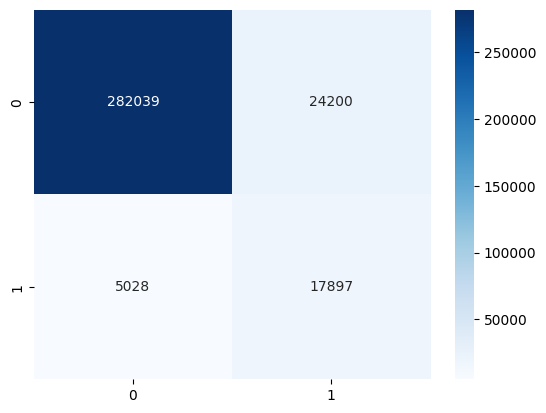

In [22]:
# 학습시킨 모델의 예측값과 실제값의 교차표 확인
ax = confusion_matrix(true_label, pred_label)
sns.heatmap(ax, annot=True, fmt='d', cmap='Blues')

In [23]:
# 학습시킨 모델의 평가 지표 확인
print(classification_report(true_label, pred_label, target_names=['Normal', 'Attack']))

              precision    recall  f1-score   support

      Normal       0.98      0.92      0.95    306239
      Attack       0.43      0.78      0.55     22925

    accuracy                           0.91    329164
   macro avg       0.70      0.85      0.75    329164
weighted avg       0.94      0.91      0.92    329164



# Mini Challenge

*   제출 : axolotl0210@gmail.com

## Download

In [24]:
# Mini Challenge 파일 다운로드
!gdown --id 1J3D7LD_pEHE6BdsMNV8n89YbJSpyuoXB --output Mini_Challenge_Train_Dataset.csv
!gdown --id 1DwFZ1qTCTfH7eEvKHzAHuNkO0qCG91NG --output Mini_Challenge_Test_Dataset.csv

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1J3D7LD_pEHE6BdsMNV8n89YbJSpyuoXB
To: /content/Mini_Challenge_Train_Dataset.csv
100% 25.7M/25.7M [00:00<00:00, 128MB/s] 
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1DwFZ1qTCTfH7eEvKHzAHuNkO0qCG91NG
To: /content/Mini_Challenge_Test_Dataset.csv
100% 16.2M/16.2M [00:00<00:00, 99.4MB/s]


In [25]:
# 현재 디렉토리의 파일 목록 확인
!ls

Mini_Challenge_Test_Dataset.csv   sample_data			       Sample_Test_Dataset.csv
Mini_Challenge_Train_Dataset.csv  sample_random_forest_classifier.pkl  Sample_Train_Dataset.csv
Sample_Answer.csv		  sample_submission.csv


## Dataset

In [26]:
# Mini Challenge 파일 경로 설정
mini_challenge_train_file = './Mini_Challenge_Train_Dataset.csv'
mini_challenge_test_file = './Mini_Challenge_Test_Dataset.csv'

In [27]:
# Mini_Challenge_Train_Dataset 파일 불러오기
mini_challenge_train_msg = pd.read_csv(mini_challenge_train_file)
print(mini_challenge_train_msg)

         Timestamp Arbitration_ID  DLC                     Data   Class
0         0.803366            153    8  00 80 10 FF 00 FF 90 1E  Normal
1         0.803602            220    8  AA 03 27 04 09 00 39 10  Normal
2         0.804306             34    8  00 00 00 00 00 00 00 00  Normal
3         0.805939            2B0    5           1C 00 00 07 C6  Normal
4         0.806180            165    8  08 08 80 00 00 00 06 86  Normal
...            ...            ...  ...                      ...     ...
527788  243.594317             80    8  00 17 EC 09 17 11 18 7B  Normal
527789  243.594557             81    8  40 84 8A 00 00 00 00 3B  Normal
527790  243.594792            2A0    8  62 00 8A 9C 48 1F 86 05  Normal
527791  243.595026            329    8  40 BE 7E 8C 11 2F 00 10  Normal
527792  243.595260            545    8  C8 0B 00 8B 2B 00 2E 00  Normal

[527793 rows x 5 columns]


## Preprocessing

In [28]:
# Feature를 생성하기 위한 전처리 함수 정의
def challenge_preprocessing(msg):
  feature = pd.DataFrame(columns=['CAN ID',
                                  'DLC'])

  # CAN ID
  can_id = [int(i, 16) / 0x7ff for i in msg['Arbitration_ID'].values]
  feature['CAN ID'] = can_id

  # DLC
  dlc = [i / 8 for i in msg['DLC'].values]
  feature['DLC'] = dlc

  """
  Feature 추가

  """

  return feature

## Model

In [29]:
# Random Forest 모델 생성
mini_challenge_rfc = RandomForestClassifier()

## Train

In [30]:
# 정의한 전처리 함수를 이용하여 모델의 입력으로 사용될 Feature를 생성
mini_challenge_train_feature = challenge_preprocessing(msg=mini_challenge_train_msg)
print(mini_challenge_train_feature)

          CAN ID    DLC
0       0.165608  1.000
1       0.265755  1.000
2       0.025403  1.000
3       0.336102  0.625
4       0.174402  1.000
...          ...    ...
527788  0.062531  1.000
527789  0.063019  1.000
527790  0.328285  1.000
527791  0.395213  1.000
527792  0.659013  1.000

[527793 rows x 2 columns]


In [31]:
# 모델의 학습을 위해 라벨링 진행 (Normal: 0 / Attack: 1)
mini_challenge_train_label = np.array([1 if i == 'Attack' else 0 for i in mini_challenge_train_msg['Class'].values])
print(mini_challenge_train_label)

[0 0 0 ... 0 0 0]


In [32]:
# Random Forest 모델 학습
mini_challenge_rfc.fit(mini_challenge_train_feature, mini_challenge_train_label)

RandomForestClassifier()

In [33]:
# 학습시킨 Random Forest 모델 저장
joblib.dump(mini_challenge_rfc, './mini_challenge_random_forest_classifier.pkl')

['./mini_challenge_random_forest_classifier.pkl']

## Test

In [34]:
# 학습시킨 Random Forest 모델 로드
trained_mini_challenge_rfc = joblib.load('./mini_challenge_random_forest_classifier.pkl')

In [35]:
# Mini_Challenge_Test_Dataset 파일 불러오기
mini_challenge_test_msg = pd.read_csv(mini_challenge_test_file)
print(mini_challenge_test_msg)

         Timestamp Arbitration_ID  DLC                     Data
0         0.812181            43F    8  00 40 60 FF 74 84 0A 00
1         0.812421            370    8  FF 20 00 80 FF 00 00 EC
2         0.812669            440    8  FF F0 00 00 FF 88 0A 00
3         0.814001            4B0    8  00 00 00 00 00 00 00 00
4         0.814249            164    8  00 08 00 00 00 00 00 08
...            ...            ...  ...                      ...
390373  181.733643            1F1    8  08 00 00 00 00 00 00 00
390374  181.733881            220    8  A5 03 26 04 09 00 3A 10
390375  181.734126            370    8  FF 20 00 80 FF 00 00 28
390376  181.734363            43F    8  00 40 60 FF 74 70 09 00
390377  181.734604            440    8  FF A0 00 00 FF 74 09 00

[390378 rows x 4 columns]


In [36]:
# 정의한 전처리 함수를 이용하여 모델의 입력으로 사용될 Feature를 생성
mini_challenge_test_feature = challenge_preprocessing(msg=mini_challenge_test_msg)
print(mini_challenge_test_feature)

          CAN ID  DLC
0       0.531021  1.0
1       0.429897  1.0
2       0.531510  1.0
3       0.586224  1.0
4       0.173913  1.0
...          ...  ...
390373  0.242794  1.0
390374  0.265755  1.0
390375  0.429897  1.0
390376  0.531021  1.0
390377  0.531510  1.0

[390378 rows x 2 columns]


In [37]:
# 학습시킨 Random Forest 모델로 예측
mini_challenge_pred_label = trained_mini_challenge_rfc.predict(mini_challenge_test_feature)
print(mini_challenge_pred_label)

[0 0 0 ... 0 0 0]


## Submission

In [38]:
# 예측 결과 파일 생성
submission = pd.DataFrame(columns=['Number', 'Class'])
submission['Number'] = mini_challenge_test_msg.index + 1
submission['Class'] = mini_challenge_pred_label
submission.to_csv('./mini_challenge_submission.csv', index=False)
print(submission)

        Number  Class
0            1      0
1            2      0
2            3      0
3            4      0
4            5      0
...        ...    ...
390373  390374      0
390374  390375      0
390375  390376      0
390376  390377      0
390377  390378      0

[390378 rows x 2 columns]
